### Choose configuration file

In [1]:
include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d

# include("../src/config_files/2dLink.jl")
# include("../src/config_files/2dFall.jl")
include("../src/config_files/2dSwim.jl")
# include("../src/config_files/2dThrow.jl")
# include("../src/config_files/3dHinge.jl")
# include("../src/config_files/3dPrismatic.jl")
# include("../src/config_files/3dCylindrical.jl")

Config info set up.


### build joint-body chain

In [2]:
bodys, joints, system = BuildChain(config_bodys, config_joints, 
                                   config_system)
system

ndim = 2, njoint = 6, nbody = 6
ndof = 36, nudof = 8, ncdof = 28, np = 3, na = 5
udof = [3, 4, 5, 9, 15, 21, 27, 33]
udof_p = [3, 4, 5]
udof_a = [9, 15, 21, 27, 33]
nudof_HERK = 3, ncdof_HERK = 33
udof_HERK = [3, 4, 5]
gravity = [0.0, 0.0, 0.0]


### Initialize system state

In [3]:
# init system
bodys, joints, system, soln = InitSystem!(bodys, joints, system)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bodys))

nothing

### Time Marching

In [4]:
# advance in time
idx = 0
@time begin
while soln.t < tf
    # advance one step
    soln, bodys, joints, system = HERK!(soln, bodys, joints, system)
        
    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bodys))
        
    # print progress
    idx += 1
    if mod(idx,500) == 1 
        @printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
#         println("center of mass at", MassCenter(bodys, system))
    end
end
@printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
end

itr = 1, t = 0.001, dt = 1.017212e-04
itr = 501, t = 2.819, dt = 5.754051e-03
itr = 712, t = 4.001, dt = 6.066847e-03
  3.584772 seconds (5.84 M allocations: 1.085 GiB, 3.50% gc time)


### Save verts data on regulated time grid for movie in Matlab

In [5]:
using MAT
using Interpolations

# create regular time grid and acquire solutions on it
qJ_regs = Float64[]
t_reg = linspace(0,solns[end].t,length(solns))
for i = 1:system.ndof
    t_temp = ([solns[k].t for k = 1:length(solns)],)
    qJ_temp = [solns[k].qJ[i] for k = 1:length(solns)]   
    qJ_reg = interpolate(t_temp, qJ_temp, Gridded(Linear()))[t_reg]
    append!(qJ_regs, qJ_reg)
end
qJ_regs = reshape(qJ_regs,(length(solns), system.ndof))

# get verts info based on this regular grid solution
vs_reg = []
bodys_reg = deepcopy(bodys)
joints_reg = deepcopy(joints)
system_reg = deepcopy(system)
for i = 1:length(solns)
    bodys_reg, joints_reg, system_reg = UpdatePosition!(bodys_reg, joints_reg, system_reg, solns[i].qJ)
    push!(vs_reg, VertsHistory(system.nbody, bodys_reg))
end

# write to .mat file for animation
# vs_reg follow the form [ntime][nbody, nverts, xyz]
matwrite("../matlab_plot/verts_i.mat", Dict(
    "ndim" => system.ndim,
    "nbody" => system.nbody,
    "nverts" => bodys[1].nverts,
    "t" => collect(t_reg),
    "verts" => vs_reg
))

### Interactive plot

Interact.Options{:SelectionSlider,Any}(1: "input" = 3 Any , "i", 3, "3", 3, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6), Dict{Any,Any}(Pair{Any,Any}(4, "4"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(3, "3"),Pair{Any,Any}(5, "5"),Pair{Any,Any}(6, "6"),Pair{Any,Any}(1, "1"))), Any[], Any[], true, "horizontal")

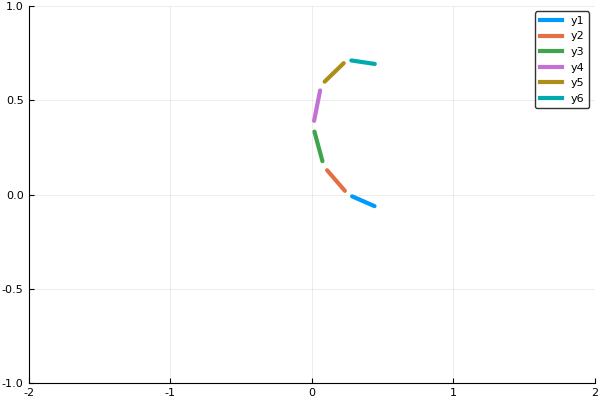

In [6]:
using Reactive, Interact
using Plots
pyplot()

# set intervals of plotting
freq = 100

@manipulate for i in 1:Int(round(length(t_reg)/freq)-1)

    if system.ndim == 2
        k = i*freq+1
        # first body
        plot(vs_reg[k][1,2:3,1],vs_reg[k][1,2:3,2], linewidth=3)
        # the rest bodys
        for j in 2:system.nbody
        plot!(vs_reg[k][j,2:3,1],vs_reg[k][j,2:3,2], linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-1,1))
    else
        k = i*freq+1
        h = [1:bodys[1].nverts;1]
        plot(vs_reg[k][1,h,1],vs_reg[k][1,h,2],vs_reg[k][1,h,3]
             , linewidth=3)
        # the rest bodys
        for j in 2:system.nbody
        plot!(vs_reg[k][j,h,1],vs_reg[k][j,h,2],vs_reg[k][j,h,3]
              , linewidth=3)
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), zlims=(-1,1))        
    end

end

### Results printed and code efficiency analysis

In [7]:
# # results printed
# solns[end].qJ
# solns[end].v
# solns[end].v̇
# solns[end].λ
# solns[end].t

# # code analysis
# using BenchmarkTools, Compat
# @benchmark HERK!(soln, bodys, joints, system, scheme, tol)
# @profile HERK!(soln, bodys, joints, system, scheme, tol)
# Profile.print()

# using Coverage
# m = analyze_malloc("../src")
# m[end-20:end]